# Installs & Imports

In [ ]:
!pip install -qq youtube_dl

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torchvision.models import resnet50
from torchvision.utils import save_image
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from PIL import Image
import random
import time
import os
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
import youtube_dl
import cv2
import requests
%config InlineBackend.figure_format = 'retina'
from collections import Counter
import shutil
import contextlib
from pathlib import Path
from pprint import pprint

# Classes & Functions

## Dataset Utilities

In [ ]:
class YouTubeDataset(Dataset):
    '''Builds a dataset from a video path'''

    def __init__(self, video_path, limit=None, transform=None, precache=False):
        self.cap = cv2.VideoCapture(video_path)
        self.n_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.idxs = []
        self.limit = limit or float('inf')
        self.transform = transform
        self.precache = precache
        self.cache = {}
        if self.precache:
            for i in range(len(self)):
                _ = self.__getitem__(i)

    def __len__(self):
        return min(self.n_frames, self.limit)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        if len(self.idxs) >= self.limit:
            raise IndexError
        new_idx = int(random.random() * self.n_frames)
        self.idxs.append(new_idx)
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, new_idx)
        _, frame = self.cap.read()
        if self.transform is not None:
            res = self.transform(Image.fromarray(frame)), 0
        else:
            res = frame, 0
        self.cache[idx] = res
        return res

class MultiDataset(Dataset):
    '''Builds a dataset from several other datasets'''
    
    def __init__(self, datasets, shuffle=False):
        self.datasets = datasets
        self.shuffle = shuffle
        self.cache = {}

        self.counts = [0 for _ in self.datasets]
        self.sizes = [len(ds) for ds in self.datasets]
        self.total_size = sum(self.sizes)

        items = []
        for i, ds in enumerate(self.datasets):
            new_items = [(i, j) for j in range(len(ds))]
            items.extend(new_items)
        if shuffle:
            random.shuffle(items)
        self.order = items

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        if not (0 <= idx < self.total_size):
            raise IndexError

        if idx in self.cache:
            return self.cache[idx]
            
        i, j = self.order[idx]
        x, y = self.datasets[i][j]
        res = self.cache[idx] = x, y
        return res

def split_dataset(dataset, train_pctg=0.8):
    n_train = int(len(dataset) * train_pctg)
    n_test = len(dataset) - n_train
    train_subset, test_subset = random_split(dataset, [n_train, n_test])
    return train_subset, test_subset

In [ ]:
def download_videos(urls, data_dir='videos', ydl_params=None):
    data_dir = Path(data_dir)
    ydl_params = ydl_params or {'outtmpl': str(data_dir / '%(id)s.%(ext)s'),
                                'format': '18',
                                'ignoreerrors': True,}
    ydl = youtube_dl.YoutubeDL(ydl_params)

    video_paths = []
    for url in urls:
        with ydl:
            result = ydl.extract_info(url, download=True)
        if 'entries' in result:
            video = result['entries'][0]
        else:
            video = result

        id_, ext = video['id'], video['ext']
        video_path = str(data_dir / f"{id}.{ext}")

        cap = cv2.VideoCapture(video_path)
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"{video_path} {n_frames} frames")
        
        video_paths.append(video_path)
    return video_paths

def download_playlist(url, data_dir='videos', limit=None, ydl_params=None):
    data_dir = Path(data_dir)
    ydl_params = ydl_params or {'outtmpl': str(data_dir / '%(id)s.%(ext)s'),
                                'format': '18',
                                'ignoreerrors': True,
                                'playlistend': limit,}
    ydl = youtube_dl.YoutubeDL(ydl_params)
    video_paths = []
    with ydl:
        result = ydl.extract_info(url, download=True)
        for entry in result['entries']:
            if entry:
                id, ext = entry['id'], entry['ext']
                video_path = str(data_dir / f"{id}.{ext}")

                cap = cv2.VideoCapture(video_path)
                n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                print(f"{video_path} {n_frames} frames")

                video_paths.append(video_path)
    return video_paths

In [ ]:
def write_snippets(snippets, data_dir='data'):
    with contextlib.suppress(FileNotFoundError):
        os.remove(f'{data_dir}.zip')
    shutil.rmtree(f'{data_dir}', ignore_errors=True)
    data_dir = Path(data_dir) / 'snippets'
    os.makedirs(data_dir, exist_ok=True)
    for i, snippet in enumerate(snippets):
        c = snippet['class']
        class_dir = data_dir / c
        if not class_dir.exists():
            os.makedirs(class_dir)
        image_path = class_dir / f"{i}.png"
        try:
            Image.fromarray(snippet['data']).save(str(image_path), "PNG")
        except:
            pass

## ResnetVAE

In [ ]:
def conv2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = (np.floor((img_size[0] + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0] + 1).astype(int),
                np.floor((img_size[1] + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1] + 1).astype(int))
    return outshape

def convtrans2D_output_size(img_size, padding, kernel_size, stride):
    # compute output shape of conv2D
    outshape = ((img_size[0] - 1) * stride[0] - 2 * padding[0] + kernel_size[0],
                (img_size[1] - 1) * stride[1] - 2 * padding[1] + kernel_size[1])
    return outshape


class ResNetVAE(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        super(ResNetVAE, self).__init__()

        self.fc_hidden1, self.fc_hidden2, self.CNN_embed_dim = fc_hidden1, fc_hidden2, CNN_embed_dim

        # CNN architechtures
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128
        self.k1, self.k2, self.k3, self.k4 = (5, 5), (3, 3), (3, 3), (3, 3)      # 2d kernal size
        self.s1, self.s2, self.s3, self.s4 = (2, 2), (2, 2), (2, 2), (2, 2)      # 2d strides
        self.pd1, self.pd2, self.pd3, self.pd4 = (0, 0), (0, 0), (0, 0), (0, 0)  # 2d padding

        # encoding components
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)
        # Latent vectors mu and sigma
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)      # output = CNN embedding latent variables
        self.fc3_logvar = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # output = CNN embedding latent variables

        # Sampling vector
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)
        self.relu = nn.ReLU(inplace=True)

        # Decoder
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=self.k4, stride=self.s4,
                               padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=self.k3, stride=self.s3,
                               padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=self.k2, stride=self.s2,
                               padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()    # y = (y1, y2, y3) \in [0 ,1]^3
        )


    def encode(self, x):
        x = self.resnet(x)  # ResNet
        x = x.view(x.size(0), -1)  # flatten output of conv

        # FC layers
        x = self.bn1(self.fc1(x))
        x = self.relu(x)
        x = self.bn2(self.fc2(x))
        x = self.relu(x)
        # x = F.dropout(x, p=self.drop_p, training=self.training)
        mu, logvar = self.fc3_mu(x), self.fc3_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        x = self.relu(self.fc_bn4(self.fc4(z)))
        x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)
        x = self.convTrans6(x)
        x = self.convTrans7(x)
        x = self.convTrans8(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconst = self.decode(z)

        return x_reconst, z, mu, logvar

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD


def train(model, train_loader, optimizer, epoch, device='cpu', log_interval=10):
    model.train()
    losses = []
    N_count = 0
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device).view(-1, )
        N_count += X.size(0)
        optimizer.zero_grad()
        X_reconst, z, mu, logvar = model(X)
        loss = loss_function(X_reconst, X, mu, logvar)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        # show information
        if (batch_idx + 1) % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, N_count, len(train_loader.dataset), 100. * (batch_idx + 1) / len(train_loader), loss.item()))
    return losses


def validation(model, test_loader, device='cpu'):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device).view(-1, )
            X_reconst, z, mu, logvar = model(X)
            loss = loss_function(X_reconst, X, mu, logvar)
            test_loss += loss.item()  # sum up batch loss
    test_loss /= len(test_loader.dataset)
    print('\nTest set ({:d} samples): Average loss: {:.4f}\n'.format(len(test_loader.dataset), test_loss))
    return test_loss


def plot_vae(model, x):
    recon_x, z, mu, logvar = model.forward(x.unsqueeze(0).cuda())
    x = np.transpose(x, (1, 2, 0))
    recon_x = np.transpose(recon_x.cpu().detach().numpy().squeeze(), (1, 2, 0))

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(x)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(recon_x)
    plt.title('reconstructed')
    plt.axis('off')
    plt.show()

## DETR

In [ ]:
class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6, device='cpu'):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(100, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

        self.device = device
    
    def encode(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)
        return h

    def forward(self, x):

        h = self.encode(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)
        
        return {'pred_logits': self.linear_class(h), 
                'pred_boxes': self.linear_bbox(h).sigmoid()}
    
    def detect(self, im, transform=None, threshold=0.95):
        if transform is not None:
            img = transform(im).unsqueeze(0)
        else:
            img = im.unsqueeze(0)
        assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

        outputs = self(img)
        probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
        keep = probas.max(-1).values > threshold

        bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], img.shape[1:], device=self.device)
        return probas[keep], bboxes_scaled

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, shape, device='cpu'):
    _, img_h, img_w = shape
    b = out_bbox
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(device)
    b = box_cxcywh_to_xyxy(b)
    return b

In [ ]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase',
    'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
    'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant',
    'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors',
    'teddy bear', 'hair drier', 'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def crop_channel_first(im, x_min, x_max, y_min, y_max):
    im = im[:]
    return im[:, y_min:y_max+1, x_min:x_max+1]


def extract_snippets(model, dataset, max_=None, print_every=500, device='cpu'):
    snippets = []
    for i, (frame, _) in enumerate(dataset):
        if i+1 % print_every == 0:
            print(f'{int(100*(i+1)/len(dataset))}%')

        probs, boxes = model.detect(frame.to(device))

        for p, box in zip(probs, boxes):
            xmin, ymin, xmax, ymax = box.detach().cpu().numpy().astype(int)
            z = crop_channel_first(frame, xmin, xmax, ymin, ymax)
            z = z.cpu().detach().numpy()
            z = (255 * z).astype(np.uint8)
            z = np.transpose(z, (1,2,0))
            z = z[:,:,::-1]

            class_ = CLASSES[p.argmax()]
            snippet = {
                'data': z,
                'class': class_,
            }
            snippets.append(snippet)

            if max_ and len(snippets) >= max_:
                return snippets
    return snippets


def plot_detr(x, prob=np.array([]), boxes=np.array([]), transform=None):
    z = x.numpy()
    z = (255 * z).astype(np.uint8)
    z = np.transpose(z, (1,2,0))
    pil_img = Image.fromarray(z[:,:,::-1]).convert('RGB')
    
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=5))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.show()

# Run

## Get Device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print("Using", torch.cuda.device_count(), "GPU!")

cuda
Using 1 GPU!


## Data Retrieval

In [ ]:
url = "https://www.youtube.com/c/LexClips/videos"
video_paths = download_playlist(url, limit=10)

[youtube:tab] LexClips: Downloading webpage
[download] Downloading playlist: Lex Clips - Videos
[youtube:tab] playlist Lex Clips - Videos: Downloading 10 videos
[download] Downloading video 1 of 10
[youtube] 8HbfxgVwAA8: Downloading webpage
[download] videos/8HbfxgVwAA8.mp4 has already been downloaded
[download] 100% of 14.15MiB
[download] Downloading video 2 of 10
[youtube] tDpoGf4AFJs: Downloading webpage
[download] videos/tDpoGf4AFJs.mp4 has already been downloaded
[download] 100% of 22.92MiB
[download] Downloading video 3 of 10
[youtube] gZ08Tu4bITo: Downloading webpage
[download] videos/gZ08Tu4bITo.mp4 has already been downloaded
[download] 100% of 17.18MiB
[download] Downloading video 4 of 10
[youtube] l7ZT8MuZkeI: Downloading webpage
[download] videos/l7ZT8MuZkeI.mp4 has already been downloaded
[download] 100% of 15.75MiB
[download] Downloading video 5 of 10
[youtube] FlzBO-d7MNE: Downloading webpage
[download] videos/FlzBO-d7MNE.mp4 has already been downloaded
[download] 100% o

In [ ]:
transform_detr = T.Compose([
    T.ToTensor(),
])
mini_datasets = [YouTubeDataset(video_path, transform=transform_detr, limit=500) for video_path in video_paths]
youtube_dataset_detr = MultiDataset(mini_datasets, shuffle=True)

## DETR

### Load Model

In [ ]:
detr = DETR(num_classes=91, device=device).to(device)
state_dict = torch.hub.load_state_dict_from_url(
    url='https://dl.fbaipublicfiles.com/detr/detr_demo-da2a99e9.pth',
    map_location='cpu', check_hash=True)
detr.load_state_dict(state_dict)
detr.eval();

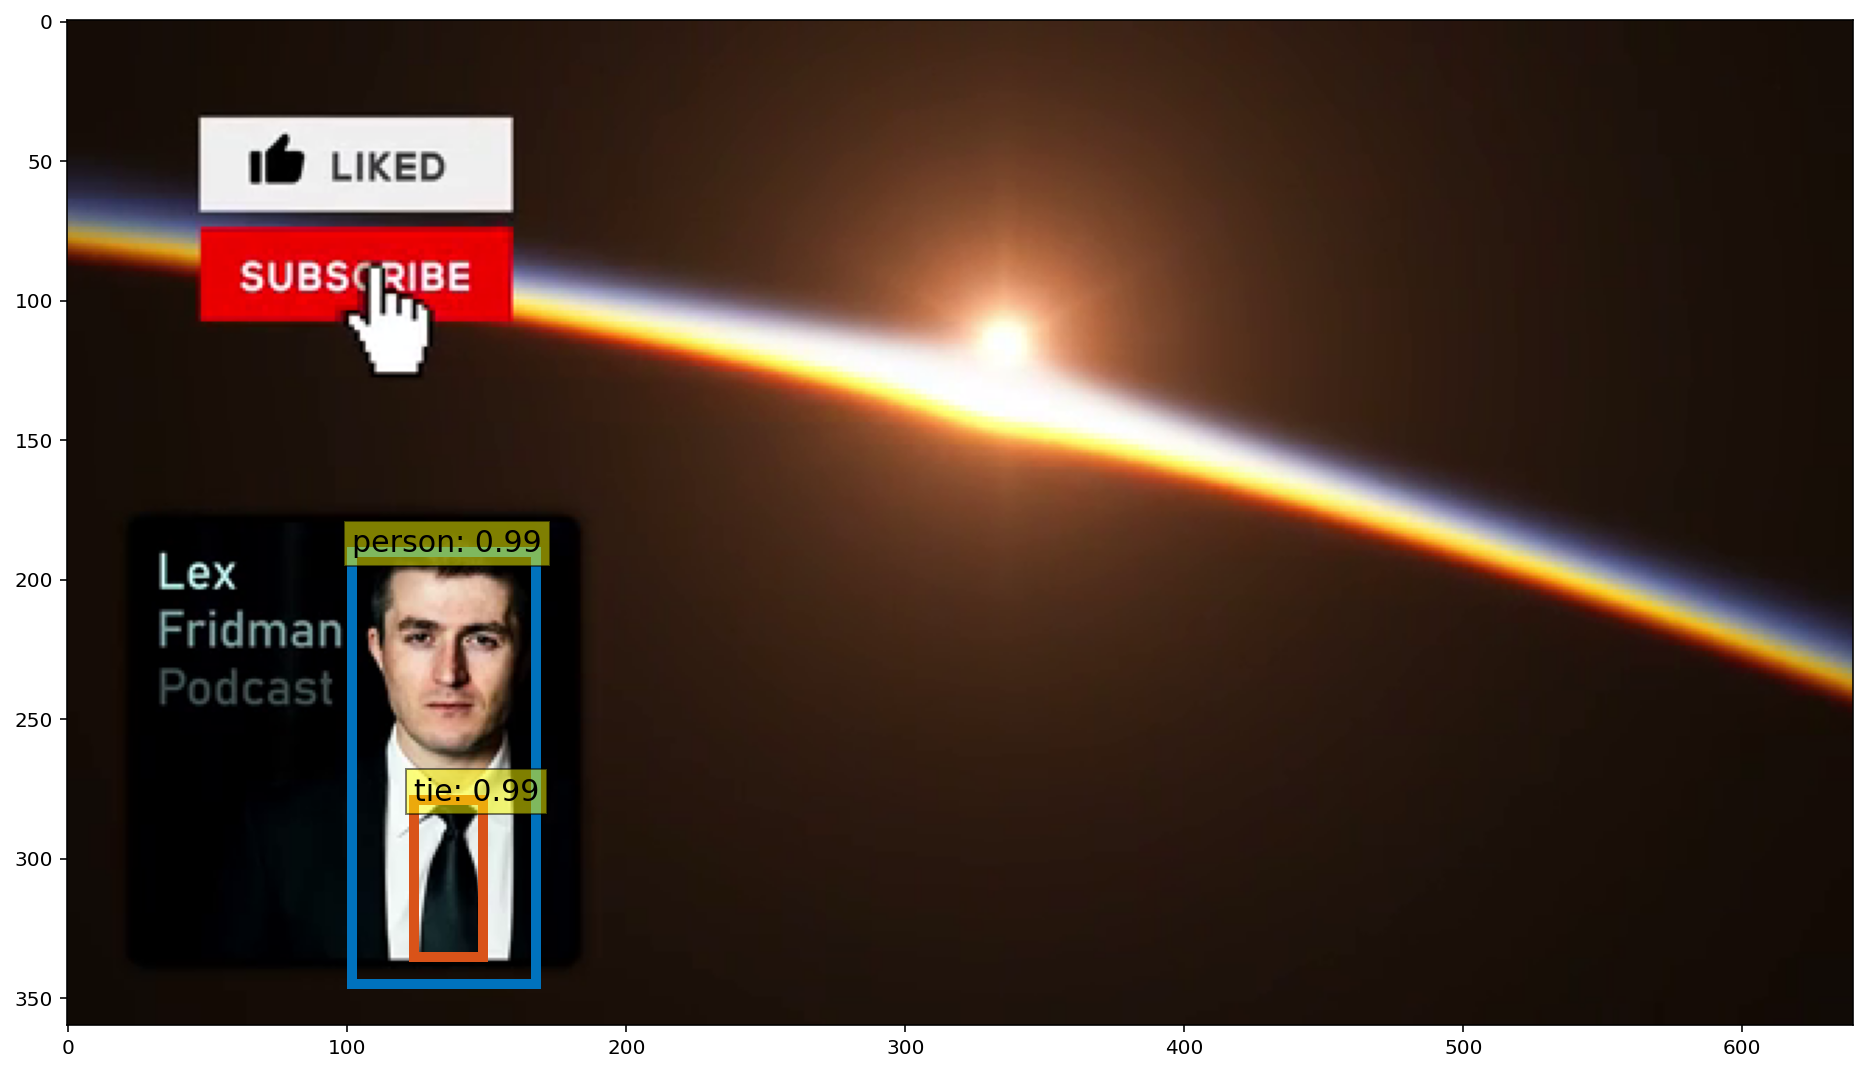

In [ ]:
x, _ = youtube_dataset_detr[1]
plot_detr(x, *detr.detect(x.to(device)))

### Extract Snippets

In [33]:
snippets = extract_snippets(detr, youtube_dataset_detr, print_every=250, device=device)

In [34]:
counts = Counter([s['class'] for s in snippets])
pprint(counts)

Counter({'bottle': 4580,
         'person': 4384,
         'tie': 1106,
         'cup': 657,
         'chair': 82,
         'remote': 4,
         'cat': 1,
         'bird': 1})


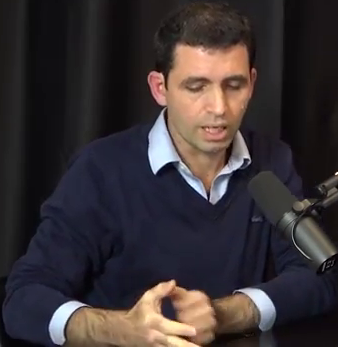

In [35]:
Image.fromarray(next(snippet for snippet in snippets if snippet['class'] == 'person')['data'])

In [36]:
write_snippets(s for s in snippets if s['class'] == 'person')

## ResNetVAE

### Prepare Data

In [37]:
transform_vae = transforms.Compose([transforms.Resize([224, 224]),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

In [38]:
youtube_person_dataset = datasets.ImageFolder('data/snippets/', transform_vae)
train_subset, test_subset = split_dataset(youtube_person_dataset, train_pctg=0.8)

batch_size = 50
train_loader = DataLoader(train_subset, batch_size=batch_size)
valid_loader = DataLoader(test_subset, batch_size=batch_size)

### Instantiate Model

In [39]:
resnet_vae = ResNetVAE(fc_hidden1=256,
                       fc_hidden2=256,
                       drop_p=0.1,
                       CNN_embed_dim=64).to(device)

### Train

In [40]:
optimizer = torch.optim.Adam(list(resnet_vae.parameters()), lr=1e-3)
epochs = 20

In [41]:
epoch_train_losses = []
epoch_test_losses = []
for epoch in range(epochs):
    train_losses = train(resnet_vae, train_loader, optimizer, epoch, device=device)
    test_loss = validation(resnet_vae, valid_loader, device=device)

    epoch_train_losses.append(train_losses)
    epoch_test_losses.append(test_loss)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Train Epoch: 1 [500/3507 (14%)]	Loss: 24076138.000000
Train Epoch: 1 [1000/3507 (28%)]	Loss: 23751984.000000
Train Epoch: 1 [1500/3507 (42%)]	Loss: 23295140.000000
Train Epoch: 1 [2000/3507 (56%)]	Loss: 22834652.000000
Train Epoch: 1 [2500/3507 (70%)]	Loss: 22655834.000000
Train Epoch: 1 [3000/3507 (85%)]	Loss: 21719936.000000
Train Epoch: 1 [3500/3507 (99%)]	Loss: 22231926.000000

Test set (877 samples): Average loss: 488536.5359

Train Epoch: 2 [500/3507 (14%)]	Loss: 21811718.000000
Train Epoch: 2 [1000/3507 (28%)]	Loss: 21963728.000000
Train Epoch: 2 [1500/3507 (42%)]	Loss: 21859666.000000
Train Epoch: 2 [2000/3507 (56%)]	Loss: 21647680.000000
Train Epoch: 2 [2500/3507 (70%)]	Loss: 21657400.000000
Train Epoch: 2 [3000/3507 (85%)]	Loss: 20870036.000000
Train Epoch: 2 [3500/3507 (99%)]	Loss: 21487468.000000

Test set (877 samples): Average loss: 464551.0639

Train Epoch: 3 [500/3507 (14%)]	Loss: 21120078.000000
Train Epoch: 3 [1000/3507 (28%)]	Loss: 21295172.000000
Train Epoch: 3 [150

### Eval

In [42]:
resnet_vae.eval();

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


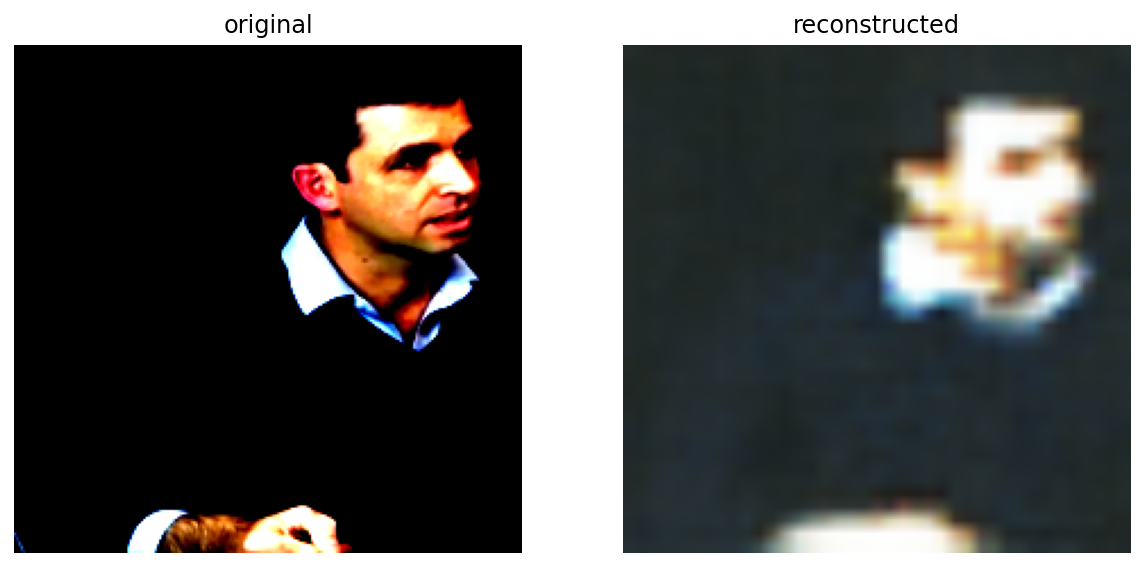

In [43]:
x, _ = train_loader.dataset[0]
plot_vae(resnet_vae, x)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


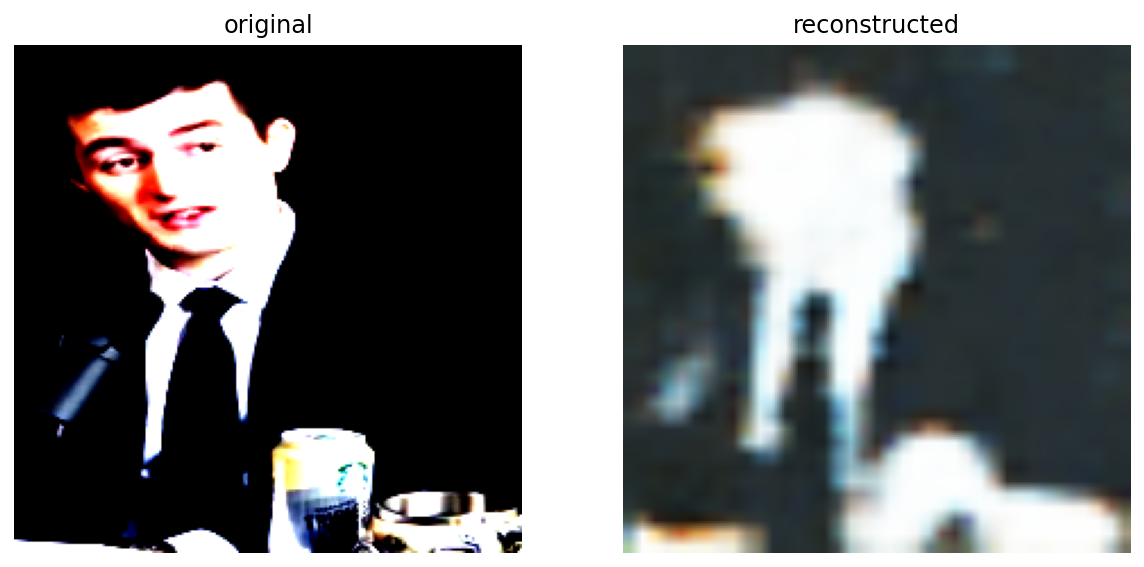

In [44]:
x, _ = train_loader.dataset[1]
plot_vae(resnet_vae, x)